Authors: Antoine A. Ruzette
Date: 2025-02-21

This notebook processes cell measurement tables exported from QuPath to plot the spatial distribution of cell-level pixel intensity in relation to a modelled stromal border. It also supports the comparison of confusion matrices between threshold- and machine learning-based cell classification.

Contains the code to plot data from images containing four channels: DAPI (nuclei), TRITC (cytokeratin), FITC (fibronectin) and CY5 (Ki67). 

In [1]:
import os
import pandas as pd
import numpy as np
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort
import re
from matplotlib.ticker import LogFormatterSciNotation
from fitter import Fitter, get_common_distributions, get_distributions

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [2]:
def load_and_preprocess_files(folder_path, file_paths, expected_columns):
    """
    Load and preprocess CSV files.

    Args:
        folder_path (str): Path to the folder containing CSV files.
        file_paths (list): List of file names.
        expected_columns (dict): Dictionary mapping expected column keys to possible names.

    Returns:
        list: A list of processed DataFrames (one per image).
        dict: Column mapping for use in plotting.
    """
    dfs = []
    final_column_mapping = {}

    for image in file_paths:
        print(f"\n🔹 Processing: {image}")
        file_path = os.path.join(folder_path, image)

        # Load CSV to check available columns first
        try:
            df_sample = pd.read_csv(file_path, nrows=1)
            available_columns = df_sample.columns.tolist()
            print(f"✅ Available Columns: {available_columns}")
        except Exception as e:
            print(f"❌ Error loading {image}: {e}")
            continue

        # Dynamically map expected column names to available ones
        column_mapping = {}
        for key, possible_names in expected_columns.items():
            for name in possible_names:
                if name in available_columns:
                    column_mapping[key] = name
                    break
            else:
                print(f"⚠️ Warning: {key} column not found in {image}. Skipping.")

        if not column_mapping:
            print(f"⚠️ Skipping {image} as no expected columns were found.")
            continue

        # Reload dataframe with only found columns
        try:
            df = pd.read_csv(file_path, usecols=list(column_mapping.values()))
        except Exception as e:
            print(f"❌ Error loading selected columns in {image}: {e}")
            continue

        # Skip this file if essential columns are missing
        essential_columns = ["DAPI", "pNDRG1_647"]
        missing_essential = [col for col in essential_columns if col not in column_mapping]
        if missing_essential:
            print(f"⚠️ Skipping {image} due to missing essential columns: {missing_essential}")
            continue

        # Remove outliers dynamically (only for present columns)
        outlier_limits = {}
        for key in ["DAPI", "pNDRG1_647", "KER_488", "FN_568"]:
            if key in column_mapping:
                col_name = column_mapping[key]
                p01 = df[col_name].quantile(0.01)
                p99 = df[col_name].quantile(0.99)
                outlier_limits[col_name] = (p01, p99)

        print(f"📊 Outlier Thresholds: {outlier_limits}")

        # Filter outliers
        df_no_outlier = df.copy()
        for col, (p01, p99) in outlier_limits.items():
            df_no_outlier = df_no_outlier[(df_no_outlier[col] >= p01) & (df_no_outlier[col] <= p99)]

        if df_no_outlier.empty:
            print(f"⚠️ Skipping {image} as it became empty after outlier removal.")
            continue

        # ✅ Store actual filename instead of "1G", "2G" etc.
        df_no_outlier["Image"] = os.path.splitext(os.path.basename(image))[0]

        dfs.append(df_no_outlier)

        # Save column mapping for later use
        final_column_mapping = column_mapping  

    if dfs:
        return dfs, final_column_mapping
    else:
        print("⚠️ No valid data loaded.")
        return [], {}


# Spatial distribution

In [14]:
# load data

folder_path =  "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/thresholds/20250328_spatial_full"

expected_columns = {
    "Class": ["Classification"],
    "Object ID": ["Object ID"],
    "DAPI": ["DAPI: Nucleus: Median"],
    "KER_488": ["KER_488: Cytoplasm: Median"],
    "pNDRG1_647": ["pNDRG1_647: Cell: Max"],
    "FN_568": ["FN_568: Cell: Median"],
    "Signed_distance": ["Signed distance to annotation Stroma µm"]
    }

file_paths = [
    "all_measurements.csv"
]


# df, _ = load_and_preprocess_files(folder_path, file_paths, expected_columns)
# df_ker488 = df[0][(df[0]['Classification'] == 'pNDRG1-: KER+')]
# df_ker488_pndrg1 = df[0][df[0]['Classification'] == 'pNDRG1+: KER+']

df, _ = load_and_preprocess_files(folder_path, file_paths, expected_columns)
df_ker488 = df[0][(df[0]['Classification'] == 'FITC KER')]
df_ker488_pndrg1 = df[0][df[0]['Classification'] == 'FITC KER: CY5 pNDRG1']

print(df_ker488.shape)
print(df_ker488_pndrg1.shape)
print(df_ker488_pndrg1.columns)


🔹 Processing: all_measurements.csv
✅ Available Columns: ['Image', 'Object ID', 'Object type', 'Name', 'Classification', 'Parent', 'ROI', 'Centroid X µm', 'Centroid Y µm', 'Detection probability', 'Nucleus: Area µm^2', 'Nucleus: Length µm', 'Nucleus: Circularity', 'Nucleus: Solidity', 'Nucleus: Max diameter µm', 'Nucleus: Min diameter µm', 'Cell: Area µm^2', 'Cell: Length µm', 'Cell: Circularity', 'Cell: Solidity', 'Cell: Max diameter µm', 'Cell: Min diameter µm', 'Nucleus/Cell area ratio', 'DAPI: Nucleus: Mean', 'DAPI: Nucleus: Median', 'DAPI: Nucleus: Min', 'DAPI: Nucleus: Max', 'DAPI: Nucleus: Std.Dev.', 'DAPI: Cytoplasm: Mean', 'DAPI: Cytoplasm: Median', 'DAPI: Cytoplasm: Min', 'DAPI: Cytoplasm: Max', 'DAPI: Cytoplasm: Std.Dev.', 'DAPI: Membrane: Mean', 'DAPI: Membrane: Median', 'DAPI: Membrane: Min', 'DAPI: Membrane: Max', 'DAPI: Membrane: Std.Dev.', 'DAPI: Cell: Mean', 'DAPI: Cell: Median', 'DAPI: Cell: Min', 'DAPI: Cell: Max', 'DAPI: Cell: Std.Dev.', 'KER_488: Nucleus: Mean', 'K

### Cropped

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/791508432.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/791508432.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/791508432.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

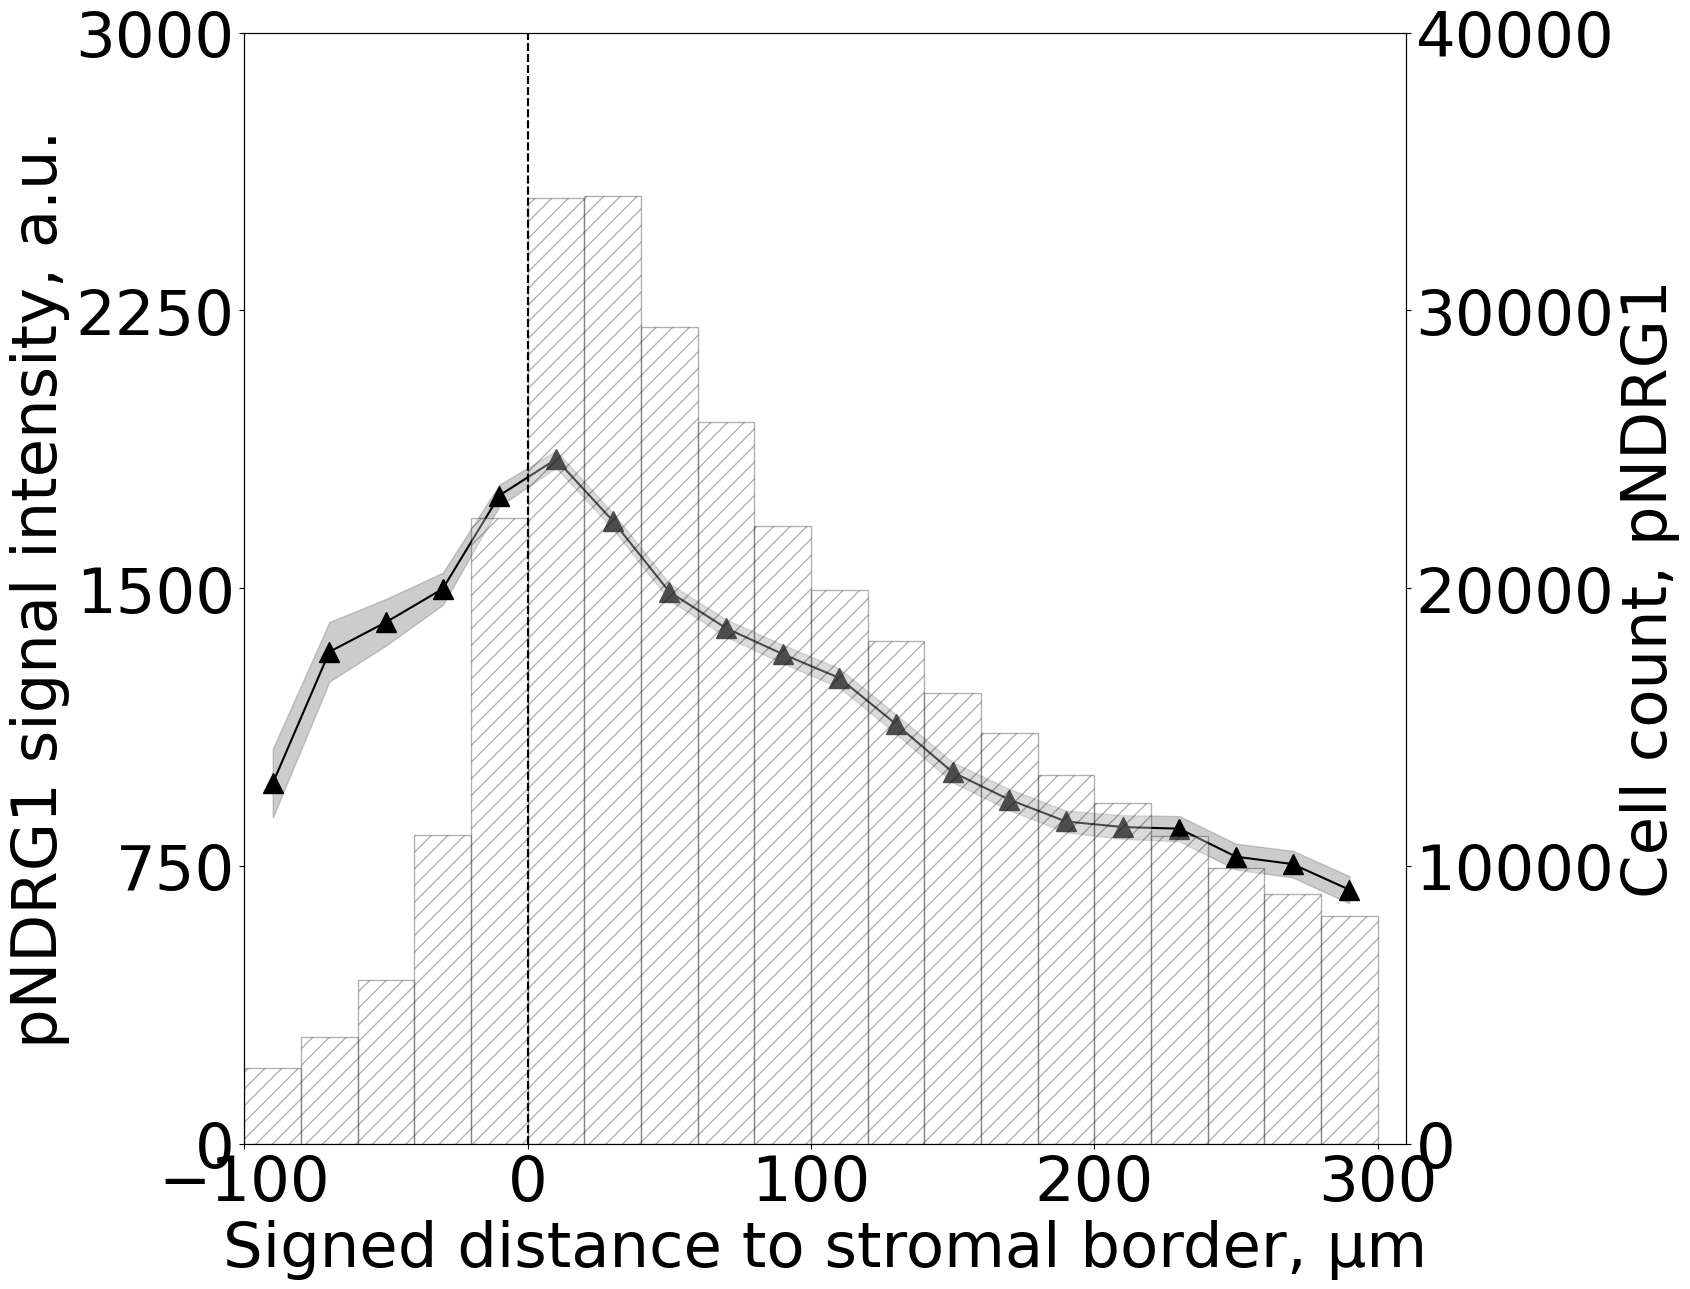

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 20
min_dist = -100
max_dist = 310

output_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/results/thresholds/20250328_spatial_full"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(df_ker488_pndrg1['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = df_ker488_pndrg1.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(df_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].median()
std_error_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = df_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# Plotting the difference line
fig, ax1 = plt.subplots(1, 1, figsize=(17, 13))

ax1.set_xlim([min_dist, max_dist])
ax1.set_ylabel(r'pNDRG1 signal intensity, a.u.', color='black', fontsize=45)
ax1.axvline(x=0, ls='--', color='black')
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='^', markersize=15, alpha=1)
ax1.set_ylim([0, None])
ax1.set_xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
ax1.tick_params(axis='both', labelsize=45)
yticks = np.linspace(0, 3000, 5)
ax1.set_yticks(yticks)

ax2 = ax1.twinx()
ax2.set_xlim([min_dist, max_dist])
ax2.set_ylabel(r'Cell count, pNDRG1', color='black', fontsize=45)
ax2.axvline(x=0, ls='--', color='black')
ax2.bar(bin_midpoints_1, combined_count, color='grey', width=bin_size, align='center', alpha=0.3, label='pNDRG1+', edgecolor='black', facecolor='white', hatch='//') # color='#f781bf'
# plt.bar(bin_midpoints_2, num_data_points_2.values, color='#377eb8', width=bin_size, align='center', alpha=0.3, label='Ki67-')
ax2.set_ylim([0, None])
ax2.set_xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
ax2.tick_params(axis='both', labelsize=45)
yticks = np.linspace(0, 40000, 5)
ax2.set_yticks(yticks)

plt.tight_layout()
plt.savefig(f"{output_path}/20252803_pNDRG1_full_combined", dpi=300, transparent=False)
plt.show()
plt.close()


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3963971719.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3963971719.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3963971719.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

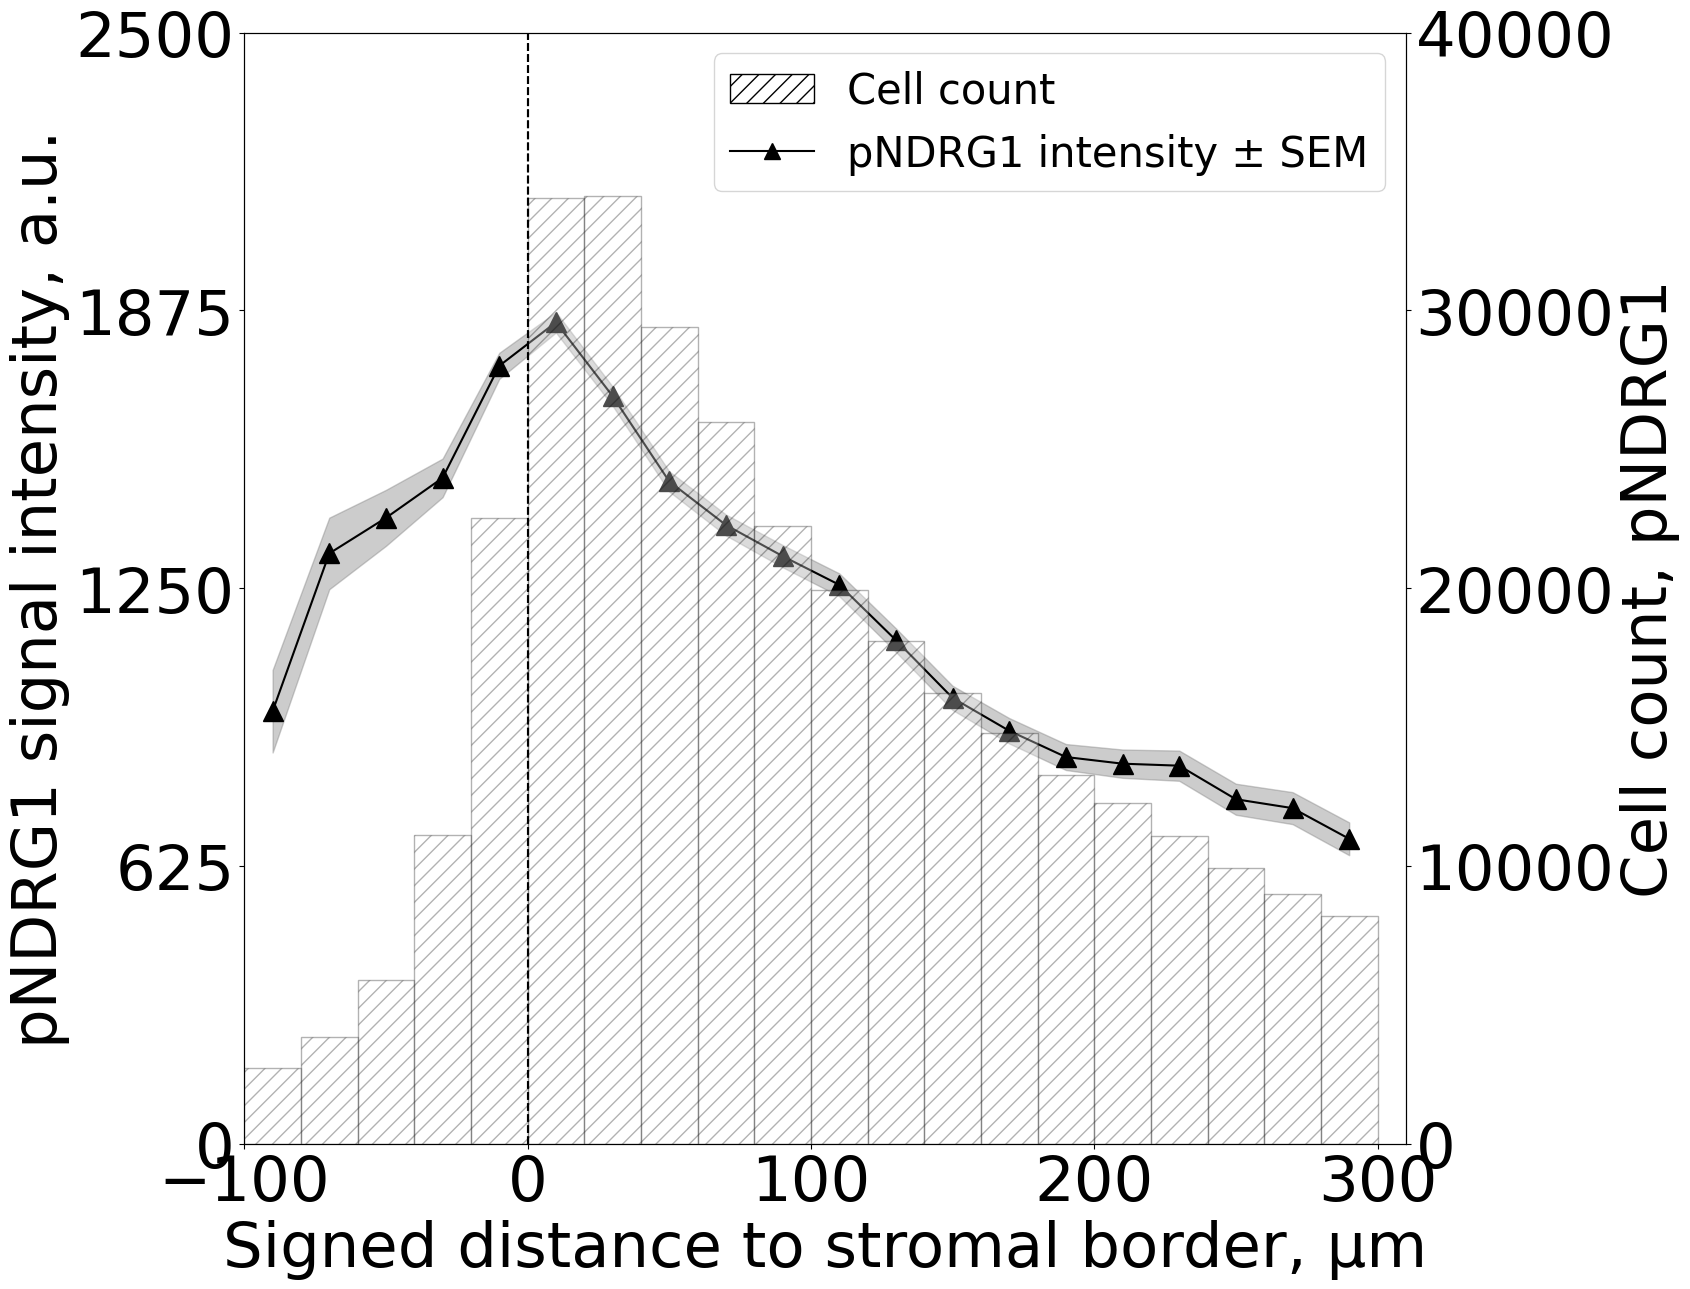

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Define bin size and create distance bins for the first set of data
bin_size = 20
min_dist = -100
max_dist = 310

output_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/spatial"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(df_ker488_pndrg1['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = df_ker488_pndrg1.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(df_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].median()
std_error_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = df_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# Plotting the difference line
fig, ax1 = plt.subplots(1, 1, figsize=(17, 13))

ax1.set_xlim([min_dist, max_dist])
ax1.set_ylabel(r'pNDRG1 signal intensity, a.u.', color='black', fontsize=45)
ax1.axvline(x=0, ls='--', color='black')

# --- Line with SEM fill ---
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='^', markersize=15, alpha=1)

ax1.set_ylim([0, None])
ax1.set_xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
ax1.tick_params(axis='both', labelsize=45)
yticks = np.linspace(0, 2500, 5)
ax1.set_yticks(yticks)

ax2 = ax1.twinx()
ax2.set_xlim([min_dist, max_dist])
ax2.set_ylabel(r'Cell count, pNDRG1', color='black', fontsize=45)
ax2.axvline(x=0, ls='--', color='black')

# Bar plot with hatch
bars = ax2.bar(bin_midpoints_1, combined_count, color='grey', width=bin_size, align='center', 
               alpha=0.3, edgecolor='black', facecolor='white', hatch='//')

ax2.set_ylim([0, None])
ax2.set_xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
ax2.tick_params(axis='both', labelsize=45)
yticks = np.linspace(0, 40000, 5)
ax2.set_yticks(yticks)

# --- Create custom legend entries ---
# 1. Custom legend for the bar plot (hatch pattern)
bar_patch = Rectangle((0, 0), 1, 1, edgecolor='black', facecolor='white', hatch='//', label="Cell Count (Bars)")

# 2. Custom legend for the intensity difference (line + shaded SEM)
line_with_fill = Line2D([0], [0], color='black', linestyle='-', marker='^', markersize=12, 
                         label="Median Intensity Difference ± SEM")
fill_patch = Rectangle((0, 0), 1, 1, color='grey', alpha=0.4)  # Invisible but represents fill

# Create the legend
legend_handles = [bar_patch, line_with_fill]
legend_labels = ["Cell count", "pNDRG1 intensity ± SEM"]

ax2.legend(handles=legend_handles, labels=legend_labels, loc='upper right', fontsize=30, frameon=True)

plt.tight_layout()
plt.savefig(f"{output_path}/20250328_pNDRG1_combined", dpi=300, transparent=False)
plt.show()
plt.close()


### Full

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3450532956.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3450532956.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_26040/3450532956.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

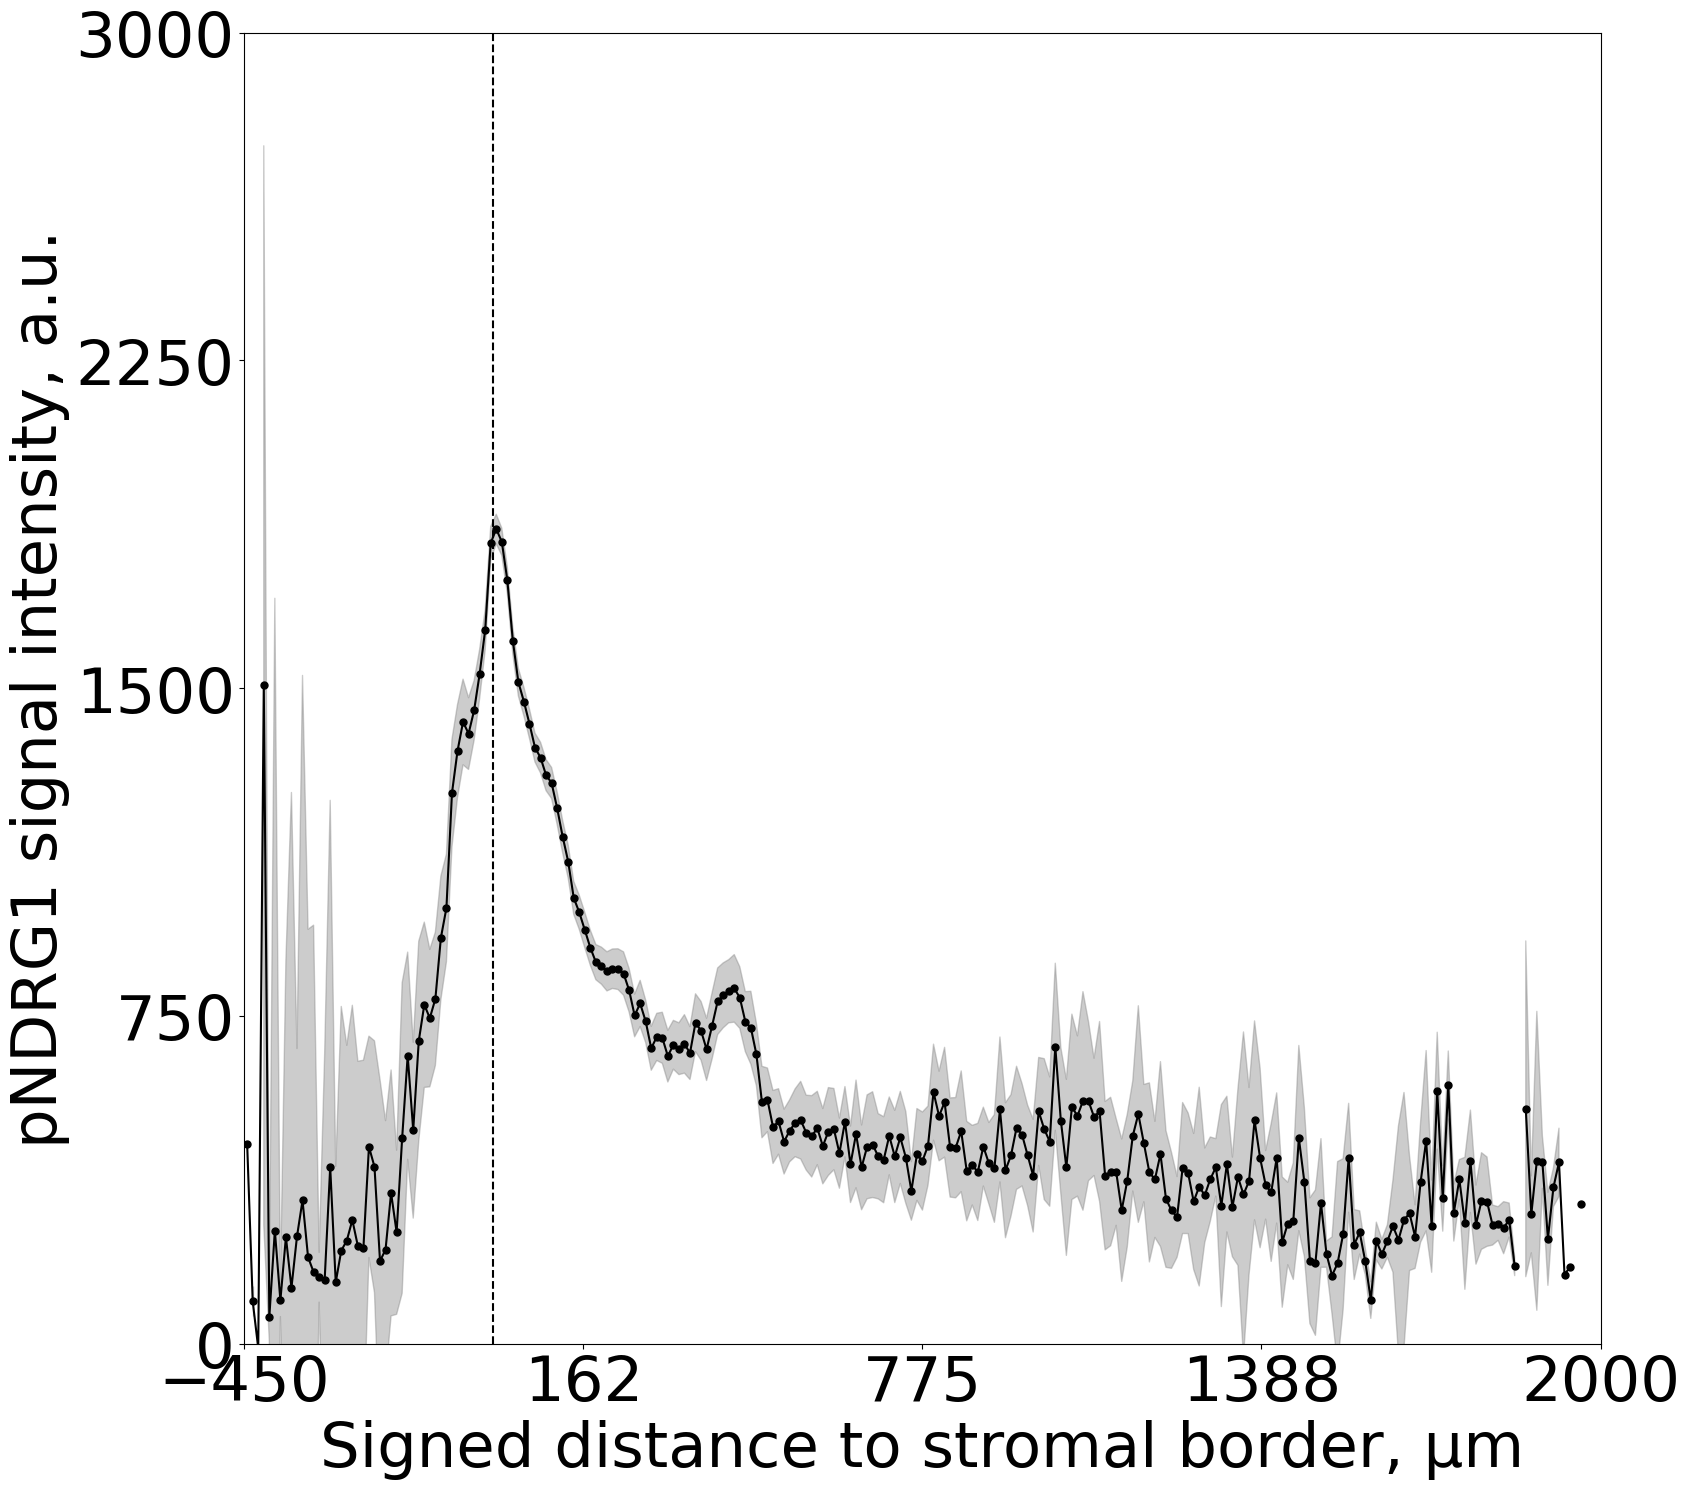

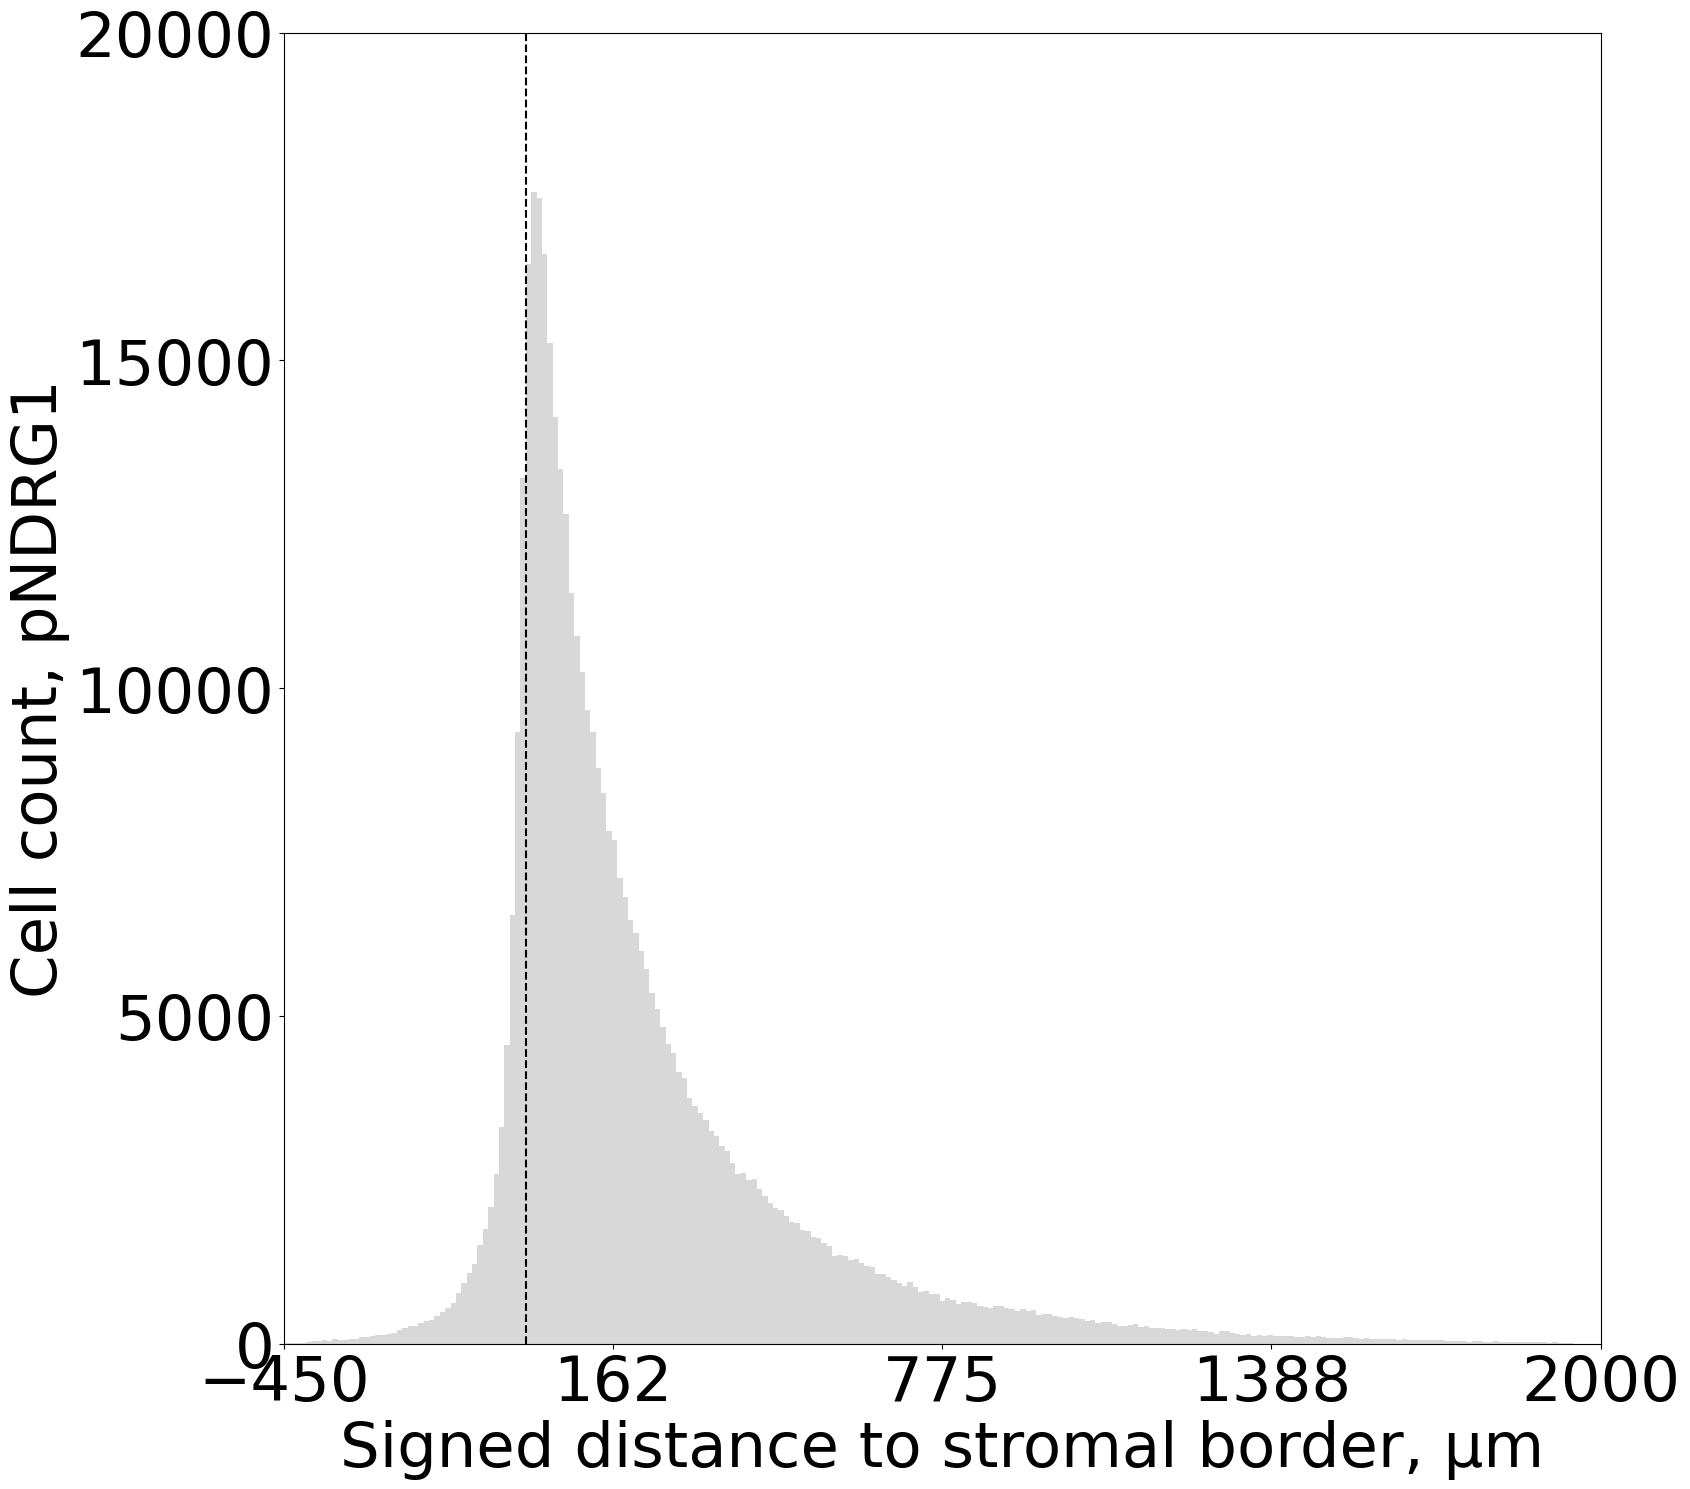

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -450
max_dist = 2000

output_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/AsPC_NDRG1/plots/spatial"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(df_ker488_pndrg1['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
std_error_1 = df_ker488_pndrg1.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = df_ker488_pndrg1.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(df_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].median()
std_error_2 = df_ker488.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = df_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

plt.figure(figsize=(17, 15))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'pNDRG1 signal intensity, a.u.', color='black', fontsize=45)
plt.axvline(x=0, ls='--', color='black')
plt.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)
plt.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1)
plt.ylim([0, None])
plt.xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
plt.tick_params(axis='both', labelsize=45)

# Set axis range and define 5 evenly spaced ticks
xticks = np.linspace(min_dist, max_dist, 5)
plt.xticks(xticks)
yticks = np.linspace(0, 3000, 5)
plt.yticks(yticks)

plt.tight_layout()
plt.savefig(f"{output_path}/20252803_pNDRG1_full_spatial_intensity", dpi=300, transparent=False)
plt.show()
plt.close()


plt.figure(figsize=(17, 15))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'Cell count, pNDRG1', color='black', fontsize=45)
plt.axvline(x=0, ls='--', color='black')
plt.bar(bin_midpoints_1, combined_count, color='grey', width=bin_size, align='center', alpha=0.3, label='pNDRG1+') # color='#f781bf'
# plt.bar(bin_midpoints_2, num_data_points_2.values, color='#377eb8', width=bin_size, align='center', alpha=0.3, label='Ki67-')
plt.ylim([0, None])
plt.xlabel(r'Signed distance to stromal border, µm', color='black', fontsize=45)
plt.tick_params(axis='both', labelsize=45)

# Set axis range and define 5 evenly spaced ticks
xticks = np.linspace(min_dist, max_dist, 5)
plt.xticks(xticks)
yticks = np.linspace(0, 20000, 5)
plt.yticks(yticks)

plt.tight_layout()
plt.savefig(f"{output_path}/20252803_pNDRG1_full_spatial_cell_count", dpi=300, transparent=False)
plt.show()
plt.close()
